This file allows for testing the GraphWorld setup with GNN implementations.
It is currently set up to test the SSL methods for the JL benchmarker.

Through this notebook you can attach a debugger.
Note that graph_tool does not work on windows, so we cannot use the graph generators.
Instead, we use the standard datasets from PyG.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from graph_world.self_supervised_learning.benchmarker import NNNodeBenchmarkerSSL
from graph_world.models.basic_gnn import GCN
from torch_geometric.datasets import Planetoid

from graph_world.self_supervised_learning.pretext_tasks.auxiliary_property_based import *
from graph_world.self_supervised_learning.pretext_tasks.contrastive_based_different_scale import *
from graph_world.self_supervised_learning.pretext_tasks.hybrid import *

dataset = Planetoid(root='/tmp/Cora', name='Cora')[0]

In [2]:
# Parameter setup (for cora)
benchmark_params = {
    'downstream_epochs' : 500,
    'pretext_epochs' : 500,
    'downstream_lr' : 3e-3,
    'pretext_lr' : 3e-3,
    'patience': 100
}

h_params = {
    'in_channels' : dataset.x.shape[1],
    'hidden_channels' : 128,
    'num_layers' : 2,
    'dropout' : 0.5,
}

pretext_params = {
    'k': 3,
    'disagreement_regularization': 0.5,
    'common_representation_regularization': 1,
}

generator_config = {
    'num_clusters' : 7,
}

training_scheme = 'JL'

pretext_task = MVMI_FT

In [3]:
# Training. You can attach a debugger to w/e is needed inside train
benchmarker = NNNodeBenchmarkerSSL(generator_config=generator_config, model_class=GCN, 
                benchmark_params=benchmark_params, h_params=h_params,
                pretext_task=pretext_task, pretext_params = pretext_params, training_scheme=training_scheme)
                
# benchmarker.SetMasks(train_mask=dataset.train_mask, val_mask=~dataset.train_mask, test_mask=~dataset.train_mask)
benchmarker.SetMasks(train_mask=dataset.train_mask, val_mask=dataset.val_mask, test_mask=dataset.test_mask)
pretext_losses, downstream_train_losses, downstream_val_losses, downstream_val_tuning_metrics, test_metrics, best_val_metrics =\
    benchmarker.train(data=dataset, tuning_metric="rocauc_ovr", tuning_metric_is_loss=False)

In [4]:
max(downstream_val_tuning_metrics)

0.793982684599931

c:\Users\danie\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\danie\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\danie\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'val_f1')]

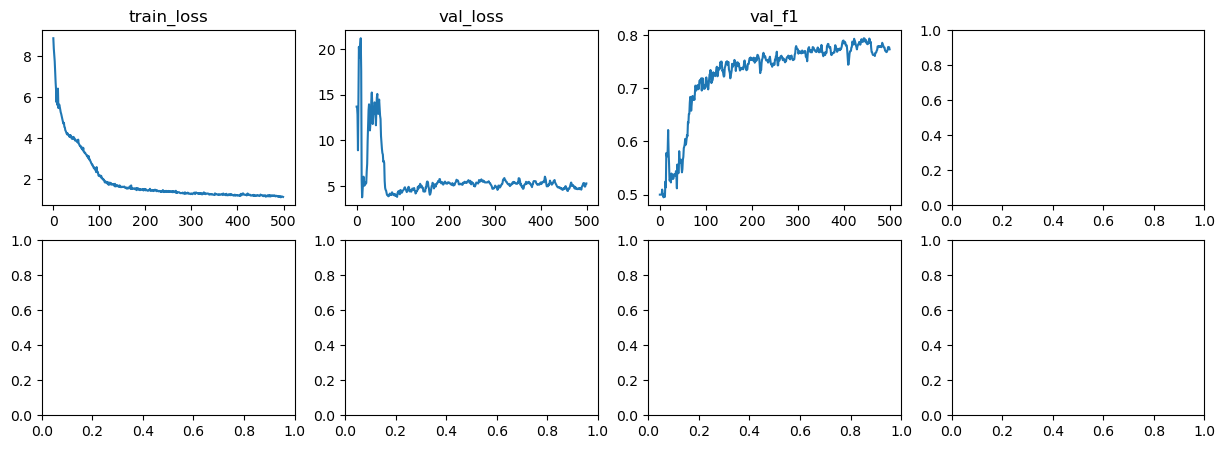

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

_, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 5))

X = np.arange(0, len(downstream_train_losses))
sns.lineplot(X, downstream_train_losses, ax=axs[0, 0]).set(title='train_loss')
sns.lineplot(X, downstream_val_losses, ax=axs[0, 1]).set(title='val_loss')
sns.lineplot(X, downstream_val_tuning_metrics, ax=axs[0, 2]).set(title='val_f1')

